In [18]:
import math
import Bio
import warnings

from Bio.PDB.MMCIFParser import MMCIFParser
from Bio.PDB import PPBuilder
from typing import List, Tuple

import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

In [19]:
AngleList = List[float]
PhiPsiTuple = Tuple[AngleList, AngleList]

def phi_psi_angles(pdb_file: str) -> PhiPsiTuple:
    pdb_structure = MMCIFParser().get_structure("tmp", pdb_file)
    
    phis, psis = [], []
    peptides = PPBuilder().build_peptides(pdb_structure)
    for peptide in peptides:
        for aminoaci, (phi, psi) in zip(peptide, peptide.get_phi_psi_list()):
            if phi and psi:
                phi, psi = map(math.degrees, (phi, psi))
                phis.append(phi)
                psis.append(psi)
    return phis, psis

def ram_plot(phi: AngleList, psi: AngleList, name: str):
    plt.figure(figsize=(9, 9))
    plt.scatter(phi, psi)
    plt.xlim(-180, 180)
    plt.ylim(-180, 180)
    plt.plot([0, 0], [-180, 180], color="black")
    plt.plot([-180, 180], [0, 0], color="black")
    plt.xlabel("$\phi$", size=14)
    plt.ylabel("$\psi$", size=14)
    plt.title(f"Ramachandran Plot. PDB ID: {name}", size=16)
    plt.grid()

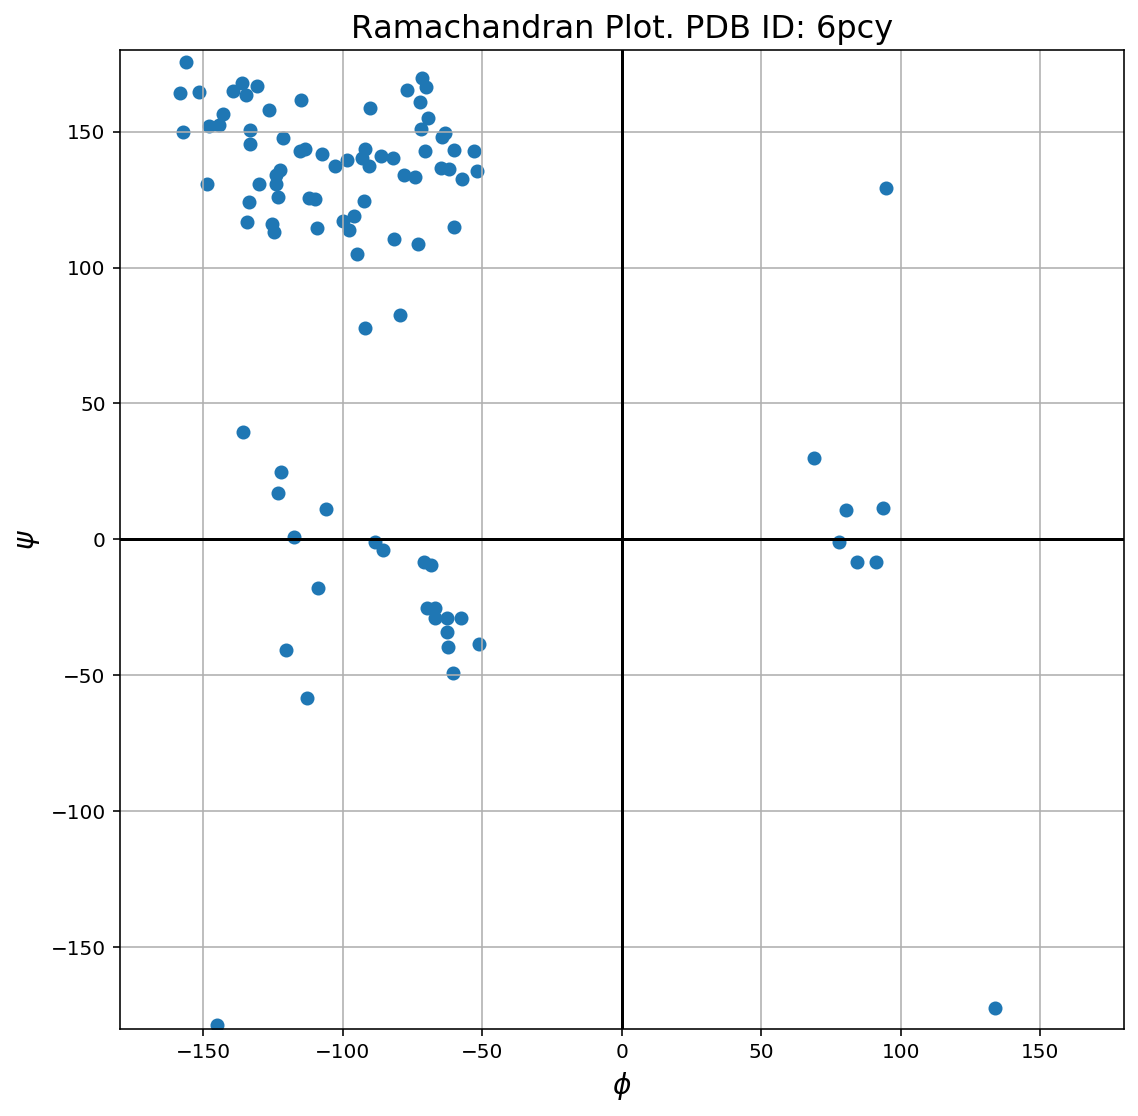

In [20]:
ram_plot(*phi_psi_angles("pdb_data/6pcy.cif"), "6pcy")

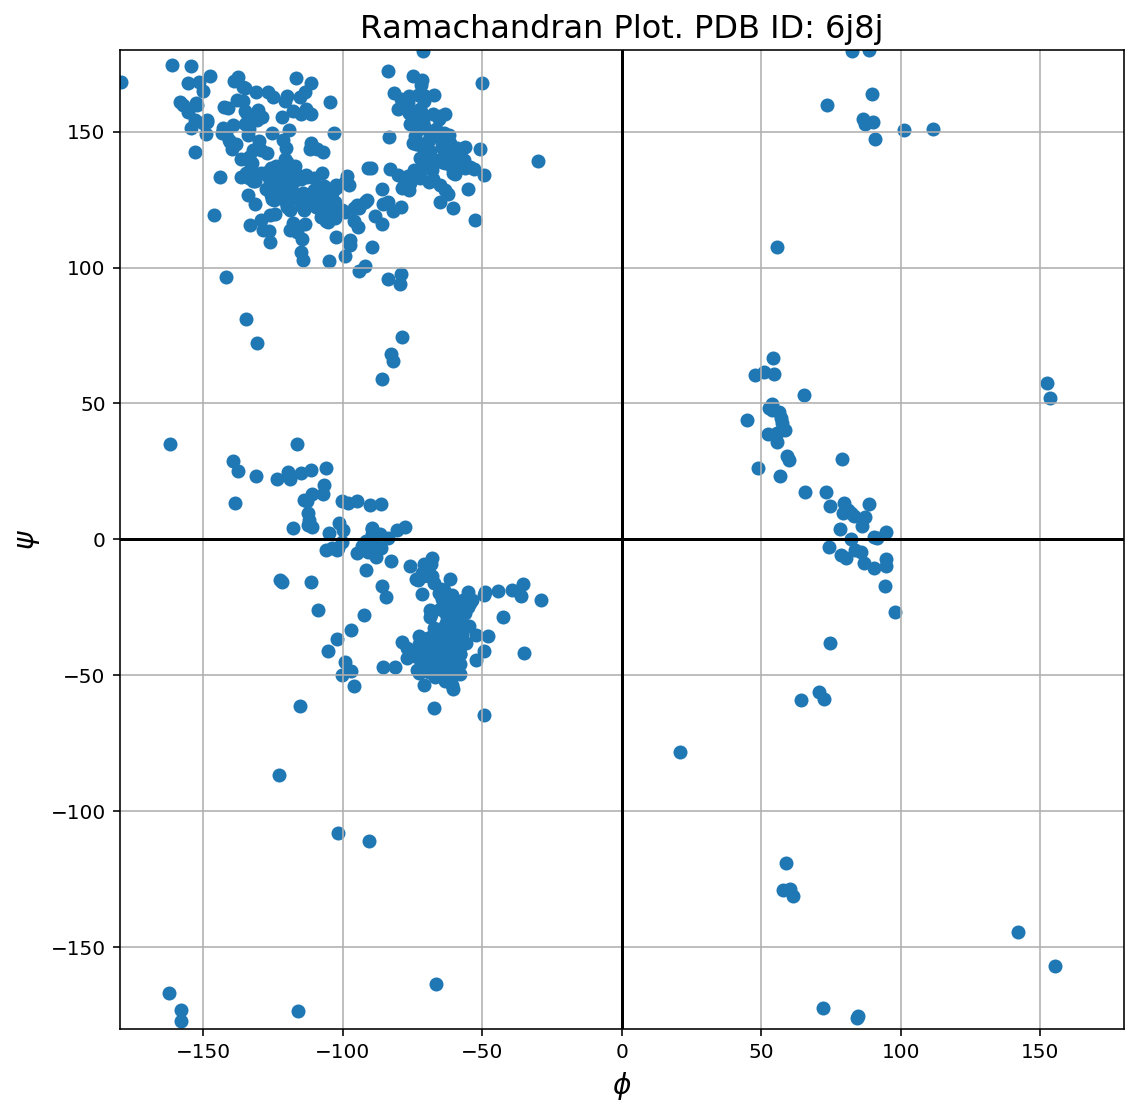

In [21]:
ram_plot(*phi_psi_angles("pdb_data/6j8j.cif"), "6j8j")

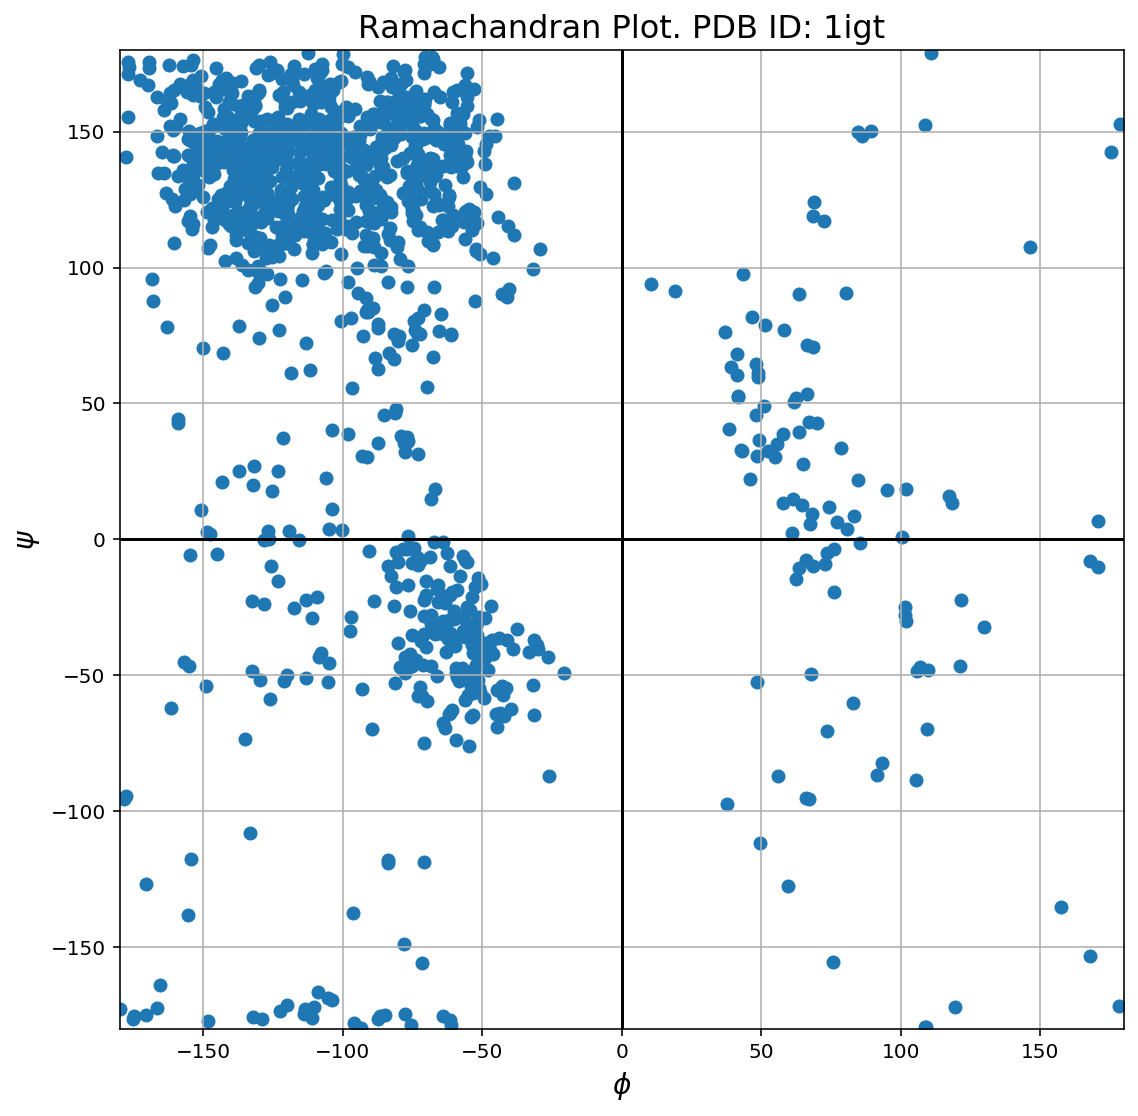

In [22]:
ram_plot(*phi_psi_angles("pdb_data/1igt.cif"), "1igt")